## Useful Functions

#### Importing Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from laserembeddings import Laser
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import math
from tqdm import tqdm
import translators as ts
from langdetect import detect
import json
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix

c:\Users\asus-zen\anaconda3\envs\py31013\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\asus-
[nltk_data]     zen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### To sum numbers in a string

In [1]:
def sum_numbers_in_string(text):
  """
  This function sums all the numbers present in a string.

  Args:
      text: The string containing numbers.

  Returns:
      The sum of all the numbers in the string. If no numbers are found, returns 0.
  """
  total_sum = 0
  current_number = ""
  for char in text:
    if char.isdigit():
      current_number += char
    else:
      if current_number:
        total_sum += int(current_number)
        current_number = ""
  # Add the last number if it exists
  if current_number:
    total_sum += int(current_number)
  return total_sum

# Example usage
string = "This is 10 a test string with 2 numbers 3 and 7."
sum_of_numbers = sum_numbers_in_string(string)
print(f"The sum of all numbers in the string is: {sum_of_numbers}")

The sum of all numbers in the string is: 22


#### Last-K Cosine Similarities Sliding Window Functions

In [2]:
#Return the average cosine similarity between the last k embeddings
def average_k_cosine_similarity(embeddings, k):
    tmp_similarity = []
    for i in np.arange(k):
        if i != k-1:
            tmp_similarity.append(np.dot(embeddings[k-1], embeddings[i]) / (np.linalg.norm(embeddings[k-1]) * np.linalg.norm(embeddings[i])))
    return np.mean(tmp_similarity)

def cosine_similarities_last_k_sliding_window (embeddings2, k):
    trial_similarities = list()
    j = k-1
    indxs = []
    for i in np.arange(len(embeddings2)-k):
        window = [emb for emb in embeddings2[i:i+k]]
        trial_similarities.append(average_k_cosine_similarity(window, k))
        indxs.append(j)
        j=j+1
    return trial_similarities, indxs

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarities_last_k_sliding_window2 (embeddings2, k):
    trial_similarities = list()
    j = k-1
    indxs = []
    for i in np.arange(len(embeddings2)-k):
        window = [emb for emb in embeddings2[i:i+k]]
        trial_similarities.append(cosine_similarity(window[k-1].reshape(1, -1), window[:k-1]).mean())
        indxs.append(j)
        j=j+1
    return trial_similarities, indxs

In [4]:
def watch_messages_in_a_range(messages, start, end, k):
    for i in np.arange(start, end):
        print(str(i) +" : " + messages[i+k-1])

#To find a suitable treshold for the cosine similarity method
def find_suitable_treshold(similarities, df):
    treshold = 0
    numofindices = 0
    totconv = totconversations(df)
    while(numofindices < totconv):
        indices = [i for i, num in enumerate(similarities) if num < treshold]
        numofindices = len(indices)
        treshold = treshold + 0.001
    return treshold

In [40]:
#Printing some info to understand the results of the cosine similarities method
def cosine_similarities_info(df, similarities, treshold, k):
    print("treshold = " + str(treshold))
    indices = [i+k-1 for i, num in enumerate(similarities) if num < treshold]
    #minindex = min(enumerate(our_group_similarities.min()))
    minimum = [i+k-1 for i, num in enumerate(similarities) if num == min(similarities)]
    print("\nIndex with the minimum cosine similarity: ")
    print(minimum)
    print("\nIndices with cosine similarity below the treshold:")
    print(indices)
    print("\nNumber of Indices Below the Treshold:")
    print(len(indices))
    print("\nNumber of Conversations in the dataframe:")
    print(totconversations(df))
    cos_indices = df.iloc[indices]
    print("\nNumber of different conversations discovered by the method:")
    print(totconversations(cos_indices))
    print("\nAccuracy:")
    print(str(totconversations(cos_indices)/totconversations(df)) + " %")

In [6]:
def print_metrics(labels, predictions):
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    print("Accuracy = " + str((tp+tn)/(tp+tn+fp+fn)))
    print("Sensitivity = " + str(tp/(tp+fn)))
    print("Specificity = " + str(tn/(tn+fp)))
    print("Precision =" + str(tp/(tp+fp)))

#### Merge Consecutive Messages from the same user

In [8]:
# Function to merge consecutive messages from the same sender in a dataframe if they are sent within a certain time frame
def merge_consecutive_messages(df,timeframe):
    ourdf = df.copy()
    k = ourdf.shape[0]-1
    i=0
    c = 0
    cons_messages_indx = []
    merged_idxs=[]
    while i < k-1:
        ourdf.reset_index(drop=True, inplace=True)
        j=i+1
        delta_timestamp = (ourdf.iloc[j]['date']-ourdf.iloc[i]['date']).seconds
        if(not math.isnan(ourdf.iloc[i]['sender'] )):
            while(ourdf.iloc[i]['sender'] == ourdf.iloc[j]['sender'] and delta_timestamp<timeframe and (ourdf.iloc[j]['reply'] == ourdf.iloc[i]['reply'] or math.isnan(ourdf.iloc[j]['reply'])) and ourdf.iloc[j]['conversation_id'] == ourdf.iloc[i]['conversation_id']):
                cons_messages_indx.append(c)
                cons_messages_indx.append(c+1)
                text = str(ourdf.iloc[i]['text']) + ". " + str(ourdf.iloc[j]['text'])
                ourdf.at[i, 'text'] = text
                ourdf.at[i,'reactions'] = ourdf.iloc[j]['reactions'] + ourdf.iloc[i]['reactions']
                
                ourdf.drop(j, inplace=True)
                ourdf.reset_index(drop=True, inplace=True)
                merged_idxs.append(i)
                k = k-1
                c = c+1
        i=i+1
        c = c+1
    return ourdf, cons_messages_indx, merged_idxs

#### To Achieve LASER Embeddings

In [9]:
#Use 'en' for english and 'it' for italian as language
def embed_dataframe(df, language):
    langs = [language for i in range(len(df['text']))]
    laser = Laser()
    embeddings = laser.embed_sentences(df['text'], lang=langs)
    return embeddings

def embed_messages(messages, language):
    langs = [language for i in range(len(messages))]
    laser = Laser()
    embeddings = laser.embed_sentences(messages, lang=langs)
    return embeddings

#### For Statitstics

In [10]:
#To count the number of reactions in the dataframe
def countreactions(df):
    return df['reactions'].apply(lambda x: sum_numbers_in_string(x)).sum()

#To count the number of different conversations in the dataframe
def totconversations(df):
    return df.groupby('conversation_id').count().shape[0]

#To compute the mean length of the conversations in the dataframe
def meanconversationlength(df):
    return df.shape[0] / totconversations(df)

#To count the number of messages per group in the dataframe
def messagespergroup(df):
    return df.groupby('group')['group'].count()

#To count the number of conversations per group in the dataframe
def conversationspergroup(df):
    convpergroup = df.groupby(['group','conversation_id'])['conversation_id'].size()
    return convpergroup.groupby('group').count()

#To compute the mean length of the conversations per group in the dataframe
def lengthofconversationspergroup(df):
    return messagespergroup(df)/conversationspergroup(df)

def printstatistics(predf):
    pd.set_option('display.max_rows', None)
    print("Total Number of Conversations:")
    print(totconversations(predf))
    print("\nTotal Number of Messages:")
    print(predf.shape[0])
    print("\nTotal Number of Reactions:")
    print(countreactions(predf))
    print("\nMessages per Conversation in average:")
    print(meanconversationlength(predf))
    print("\nConversations per group:")
    convpergroup = conversationspergroup(predf)
    print(convpergroup)

    # First plot
    plt.figure()
    colors = plt.cm.viridis(np.linspace(0, 1, len(convpergroup)))
    convpergroup.plot(kind='bar', title='#Conversations per group', color=colors)
    plt.show()  # Display the first plot

    print("Messages per Conversations per Group in Average:")
    locpergroup = lengthofconversationspergroup(predf)
    print(locpergroup)

    plt.figure()
    colors = plt.cm.viridis(np.linspace(0, 1, len(locpergroup)))
    locpergroup.plot(kind='bar', title='#Messages per Conversations per Group in Average', color=colors)
    plt.show()  # Display the first plot

#### For Pre-Processing

In [11]:

def preprocess_message(message):
  
  # Removing mentions
  message = re.sub(r"@\w+", "", message)
  # Removing links
  message = re.sub(r"(\[[^\]]+\]|https?://[^\s]+)", "", message)
  # Removing newlines
  message = re.sub(r"\n", " ", message)
  # Removing special characters
  #message = re.sub(r"[^\w\s]", " ", message)

  # Convert to lowercase
  #message = message.lower()

  # Removing empty words
  message = " ".join(message.split())

  return message

# example
messaggi = ["Ciao a tutti!", "Come va?", "Oggi è una bella giornata\n.", " "]
preprocessed_messages = [preprocess_message(message) for message in messaggi]
print(preprocessed_messages)

NameError: name 're' is not defined

In [ ]:
def remove_stopwords(message, language):
  # Get the stopwords for the specified language
  stop_words = set(stopwords.words(language))
  # Split the message into words
  words = message.split()
  # Remove the stopwords
  words = [word for word in words if word not in stop_words]
  # Join the words back into a single string
  return " ".join(words)


# example
messaggi = ["Ciao a tutti!", "Come va?", "Oggi è una bella giornata\n."]
preprocessed_messages = [remove_stopwords(message,"italian") for message in messaggi]
print(preprocessed_messages)

['Ciao tutti!', 'Come va?', 'Oggi bella giornata .']


In [ ]:
def remove_stopwords_from_messages(messages, language):
  return [remove_stopwords(message, language) for message in messages]

In [ ]:
def prerprocess_messages(messages):
    return [preprocess_message(message) for message in messages]

In [ ]:
def translate_messages(df_original):
    import translators as ts
    translation_text_google = []
    df_translated = df_original.copy()
    for i in tqdm(range(len(df_translated))):
        try:
            original_text = df_translated['text'].iloc[i]
            detected_language = detect(original_text)
            if detected_language != 'en':
                message_google = ts.translate_text(query_text=original_text, translator='google', from_language='auto', to_language='en')
                translation_text_google.append(message_google)
            else:
                translation_text_google.append(original_text)
        except:
            translation_text_google.append(original_text)

    df_translated['text'] = translation_text_google
    return df_translated

In [ ]:
def translate_texts(texts):
    translation_text_google = []
    for i in np.arange(len(texts)):
        try:
            original_text = texts[i]
            detected_language = detect(original_text)
            if detected_language != 'en':
                message_google = ts.translate_text(query_text=original_text, translator='google', from_language='auto', to_language='en')
                translation_text_google.append(message_google)
            else:
                translation_text_google.append(original_text)
        except:
            translation_text_google.append(original_text)

    return translation_text_google

#### Generate Labels

In [12]:
def calculate_time_delta(a, b):
    datetime_format = "%Y-%m-%d %H:%M:%S%z"
    a_datetime = datetime.strptime(a, datetime_format)
    b_datetime = datetime.strptime(b, datetime_format)
    time_delta = a_datetime - b_datetime
    return time_delta / timedelta(minutes=1)

In [13]:
def generate_dataset_from_labeled_data_with_sliding_window(df, window_size, embeddings):
    
    df["embedding"] = embeddings
    result_df = pd.DataFrame()
    for start_idx in tqdm(range(len(df) - window_size - 1)):
        record_df = df.iloc[start_idx : start_idx + window_size + 1]
        last_messages_conversation = record_df.iloc[-1]["conversation_id"]

        window_df = record_df.iloc[:-1]

        train_record = {
            f"reaction_ref": sum(
                json.loads(record_df.iloc[-1]["reactions"].replace("'", '"')).values()
            ),
            # "group": record_df.iloc[-1]["group"],
        }
        for i in range(window_size):
            train_record |= {
                f"reaction{i}": sum(
                    json.loads(
                        window_df.iloc[i]["reactions"].replace("'", '"')
                    ).values()
                )
            }
            train_record |= {
                f"d{i}": np.linalg.norm(
                    window_df.iloc[i]["embedding"] - record_df.iloc[-1]["embedding"]
                )
            }
            same_profile = False
            try:
                same_profile = int(record_df.iloc[-1]["sender"]) == int(
                    window_df.iloc[i]["sender"]
                )
            except:
                pass
            train_record |= {f"same_profile{i}": same_profile}

        # Setting Target Values
        train_record |= {
            "label": last_messages_conversation in window_df["conversation_id"].array
        }
        result_df = result_df._append(train_record, ignore_index=True)

    result_df = result_df.reset_index()
    return result_df

In [14]:
def extract_labels_from_labeled_data(df, window_size):
    labels = []
    idxs = []
    i = 0
    for start_idx in range(len(df) - window_size - 1):
        record_df = df.iloc[start_idx : start_idx + window_size + 1]
        last_messages_conversation = record_df.iloc[-1]["conversation_id"]
        label = last_messages_conversation in record_df.iloc[:-1]["conversation_id"].values
        labels.append(label)
        i = start_idx + window_size
        idxs.append(i)
    return labels, idxs

## Telegram Message Dataset Description

This dataset was collected by reading 300 messages from 7 different Telegram groups (2100 Messages).

### Data Fields:
- **ID:** A unique identifier for each message.
- **Group:** The name or identifier of the Telegram group from which the message originated.
- **Sender:** The username or identifier of the person who sent the message.
- **Text:** The content of the message.
- **Reply:** The ID of the message to which the current message is a reply (if applicable).
- **Date:** The date and time when the message was sent.
- **Reactions:** Information about any reactions (e.g., likes, emojis) received by the message.

### Manual Labeling:
Each conversation has been manually labeled to differentiate it from others using the "conversation_id" label.

This dataset provides a comprehensive view of interactions within various Telegram groups, allowing for analysis of communication patterns, and other forms of data analysis.


## Original dataset + Statistics

In [17]:
df = pd.read_excel('data_analysis\labeling_data.xlsx')
df = df.set_index('index')
df['date'] = pd.to_datetime(df['date'])
df.drop(columns=['Unnamed: 9'], inplace=True)

### Inspect data

In [18]:
df.head()

,id,group,sender,text,reply,date,reactions,conversation_id
index,,,,,,,,
1,21738,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,"guys hello everyone, I don't know if I'm in th...",NaN,2023-11-14 10:14:46+00:00,{},0
2,21739,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,962690321,/search infosec,21738.0,2023-11-14 13:10:56+00:00,{},0
3,21743,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,Thank you,NaN,2023-11-14 13:50:36+00:00,{},0
4,21749,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,For automation how is it?\n#Link,NaN,2023-11-16 10:04:12+00:00,{},1
5,21750,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Is there any specification on which I can focu...,NaN,2023-11-16 10:05:11+00:00,{},1


### Statistics

Total Number of Conversations:
535

Total Number of Messages:
2099

Total Number of Reactions:
319

Messages per Conversation in average:
3.9233644859813084

Conversations per group:
group
https://t.me/PoliGruppo                         106
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     70
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     44
https://t.me/joinchat/RL4pXSkXipyuKDmd           75
https://t.me/joinchat/aiAC6RgOjBRkYjhk           94
https://t.me/joinchat/qyxbq_vZ5f4xYzg0           26
https://t.me/joinchat/rLRXuuItcHtkMTVk          120
Name: conversation_id, dtype: int64


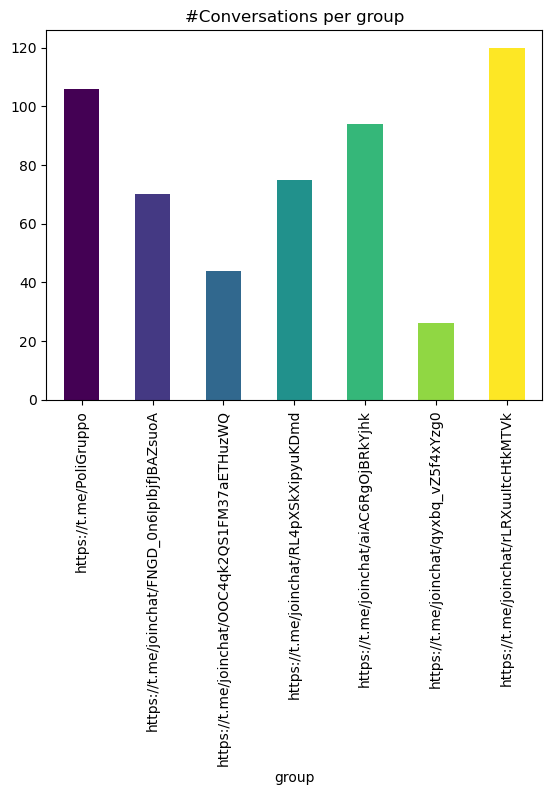

Messages per Conversations per Group in Average:
group
https://t.me/PoliGruppo                          2.830189
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     4.285714
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     6.795455
https://t.me/joinchat/RL4pXSkXipyuKDmd           4.000000
https://t.me/joinchat/aiAC6RgOjBRkYjhk           3.191489
https://t.me/joinchat/qyxbq_vZ5f4xYzg0          11.538462
https://t.me/joinchat/rLRXuuItcHtkMTVk           2.500000
dtype: float64


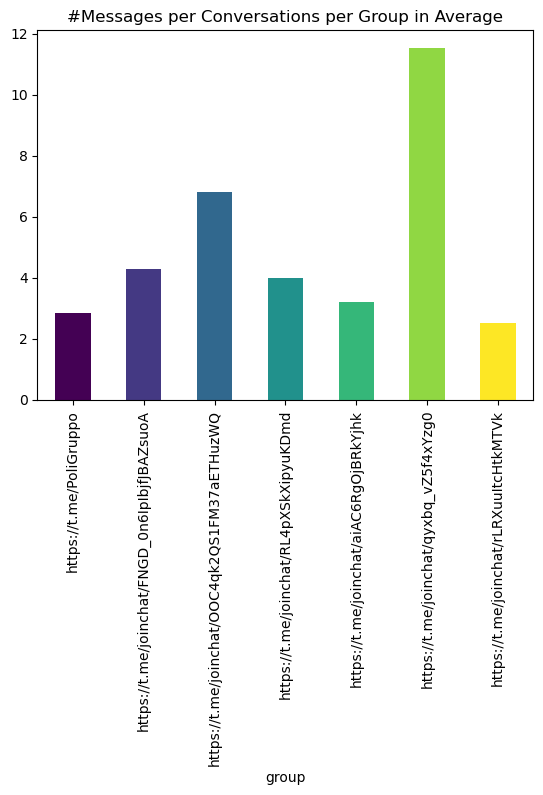

In [21]:
printstatistics(df)

### Embedding all the messages of the dataframe using LASER:

In [19]:
embeddings = embed_dataframe(df,'en')

In [20]:
embeddings.shape

(2099, 1024)

#### Adding the labels

In [28]:
k1 = 5
emb = [emb1 for emb1 in embeddings]

labels, idxs = extract_labels_from_labeled_data(df, k1)
labeled_df = df.copy()
labeled_df = labeled_df.iloc[idxs]
labeled_df.reset_index(drop=True, inplace=True)
labeled_df.insert(0, 'label', labels)

In [29]:
len(labels)

2093

In [30]:
len(labeled_df)

2093

In [31]:
labeled_df.head()

,label,id,group,sender,text,reply,date,reactions,conversation_id
0,False,21752,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,1010012648,"Hi, sorry, I would like to know if these 2 PCs...",NaN,2023-11-16 10:34:11+00:00,{},2
1,True,21760,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,I would say that you are already at the lower ...,21750.0,2023-11-16 16:25:39+00:00,{},1
2,True,21761,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,"Yes, they both have excellent characteristics,...",21752.0,2023-11-16 16:27:30+00:00,{'👍': 1},2
3,True,21762,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Well it seems good to me good except the medio...,21760.0,2023-11-16 16:58:04+00:00,{},1
4,True,21763,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,If it costs so little you don't have a good pc,21762.0,2023-11-16 16:59:47+00:00,{},1


In [32]:
labels = labeled_df['label']
len(labels)

2093

In [33]:
df.shape[0]-len(labels)

6

## Testing the Cosine Similaritites Method on the Original Dataset

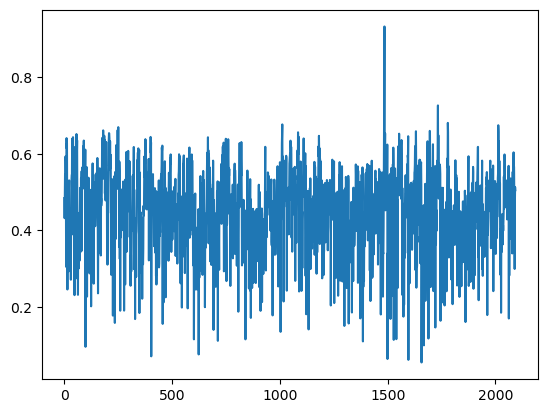

In [41]:
og_similarities, indxs = cosine_similarities_last_k_sliding_window(emb, k1+1)
plt.plot(og_similarities)
plt.show()

In [35]:
len(og_similarities)

2093

In [36]:
similarities_messages = df.iloc[indxs]
similarities_messages.reset_index(drop=True, inplace=True)
similarities_messages.insert(0, 'cosine_similarity_prediction', og_similarities)
similarities_messages.insert(0, 'label', labels)
similarities_messages.head()


,label,cosine_similarity_prediction,id,group,sender,text,reply,date,reactions,conversation_id
0,False,0.484731,21752,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,1010012648,"Hi, sorry, I would like to know if these 2 PCs...",NaN,2023-11-16 10:34:11+00:00,{},2
1,True,0.432101,21760,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,I would say that you are already at the lower ...,21750.0,2023-11-16 16:25:39+00:00,{},1
2,True,0.481724,21761,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,"Yes, they both have excellent characteristics,...",21752.0,2023-11-16 16:27:30+00:00,{'👍': 1},2
3,True,0.546239,21762,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Well it seems good to me good except the medio...,21760.0,2023-11-16 16:58:04+00:00,{},1
4,True,0.519294,21763,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,If it costs so little you don't have a good pc,21762.0,2023-11-16 16:59:47+00:00,{},1


In [42]:
cosine_similarities_info(df, og_similarities, 0.5, k1+1)

treshold = 0.5

Index with the minimum cosine similarity: 
[1662]

Indices with cosine similarity below the treshold:
[5, 6, 7, 13, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 42, 52, 53, 54, 55, 56, 57, 58, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 81, 86, 103, 105, 106, 107, 108, 110, 111, 113, 115, 116, 118, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143, 144, 145, 146, 148, 149, 151, 152, 157, 160, 161, 162, 163, 164, 165, 166, 167, 168, 171, 173, 174, 175, 176, 177, 178, 193, 196, 201, 203, 204, 205, 206, 207, 208, 221, 222, 223, 224, 225, 226, 227, 230, 231, 232, 233, 234, 235, 237, 239, 242, 243, 244, 259, 262, 264, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 279, 280, 281, 282, 283, 284, 285, 287, 289, 290, 292, 294, 298, 302, 303, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 328, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 

In [43]:
df.iloc[1650:1665]

,id,group,sender,text,reply,date,reactions,conversation_id
index,,,,,,,,
1651,44880,https://t.me/joinchat/aiAC6RgOjBRkYjhk,554966961,You can change the exams of the second,44879.0,2023-12-18 14:21:01+00:00,{'👍': 1},1601
1652,44883,https://t.me/joinchat/aiAC6RgOjBRkYjhk,1646523482,Sorry but if in the second half of the second ...,NaN,2023-12-18 16:28:07+00:00,{},1602
1653,44884,https://t.me/joinchat/aiAC6RgOjBRkYjhk,554966961,No you can only give it from April/June of the...,44883.0,2023-12-18 16:29:50+00:00,{},1602
1654,44890,https://t.me/joinchat/aiAC6RgOjBRkYjhk,797326614,"Pardon curiosity, why? Having inserted it in S...",44884.0,2023-12-20 12:04:07+00:00,{},1602
1655,44891,https://t.me/joinchat/aiAC6RgOjBRkYjhk,1182159515,"No, because the lessons of teaching has been c...",44890.0,2023-12-20 12:32:20+00:00,{},1602
1656,44892,https://t.me/joinchat/aiAC6RgOjBRkYjhk,797326614,"Ahhh clear, I didn't know, so it is as if they...",44891.0,2023-12-20 14:34:47+00:00,{'❤': 1},1602
1657,44893,https://t.me/joinchat/aiAC6RgOjBRkYjhk,1182159515,In practice yes,44892.0,2023-12-20 14:42:25+00:00,{'👍': 1},1602
1658,44895,https://t.me/joinchat/aiAC6RgOjBRkYjhk,475307226,Exact. The basic concept is that you cannot gi...,44892.0,2023-12-20 22:14:18+00:00,{'👍': 1},1602
1659,44899,https://t.me/joinchat/aiAC6RgOjBRkYjhk,1070528679,"Good morning, can someone confirm me if it is ...",NaN,2023-12-23 09:24:02+00:00,{},1603


In [32]:
treshold = find_suitable_treshold(og_similarities, df)
predictions = [False if sim <= treshold else True for sim in og_similarities]


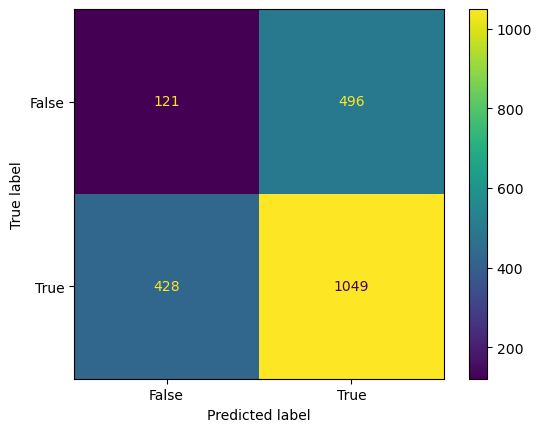

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(labels, predictions)

plt.show()

In [34]:
print_metrics(labels, predictions)

Accuracy = 0.5587392550143266
Sensitivity = 0.7102234258632363
Specificity = 0.19611021069692058
Precision =0.6789644012944984


In [35]:
def return_metrics(labels, predictions):
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    return accuracy, sensitivity, specificity, precision

In [36]:
def test_cosine_similarity_method(df, embeddings, k, treshold):
    labels, lbl_indxs = extract_labels_from_labeled_data(tmp_df, k)
    og_similarities, indxs = cosine_similarities_last_k_sliding_window(emb, k+1)
    predictions = [False if sim <= treshold else True for sim in og_similarities]
    #print_metrics(labels, predictions)
    return labels, predictions

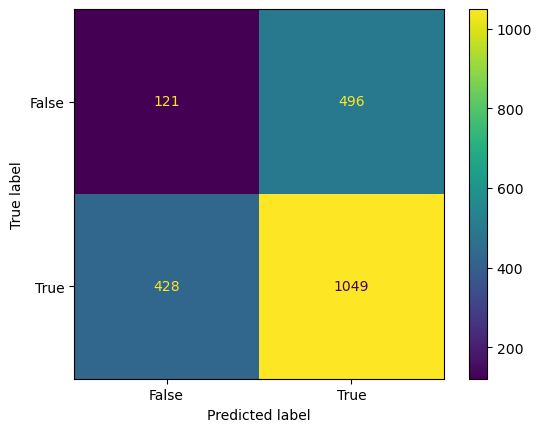

In [37]:
tmp_df = df.copy()
emb = [emb1 for emb1 in embeddings]
tmp_df.insert(0, 'embedding', emb)
tr = find_suitable_treshold(og_similarities, df)

labels, predictions = test_cosine_similarity_method(tmp_df, emb, k1, tr)
ConfusionMatrixDisplay.from_predictions(labels, predictions)

#### Results with Original Dataset

In [65]:
from tabulate import tabulate
import numpy as np



def print_results_table(df, embeddings, ki, ke):
    headers = ["Window Size"]
    range = np.arange(-0.1, 0.12, 0.02)
    range = range.tolist()
    np.set_printoptions(formatter={'float':"{0:0.2f}".format})
    for h in range:
        if h < 0.01 and h > -0.01:
            value = "T"
        elif h > 0:
            value = "T+"+str(np.around(h,2))
        elif h < 0:
            value = "T" + str(np.around(h,2))

        headers.append(value)

    myTable = []
    range = np.arange(ki, ke+1)
    range = range.tolist()
    for k in range:
        row = [k]
        og_similarities, indxs = cosine_similarities_last_k_sliding_window(embeddings, k+1)
        treshold = find_suitable_treshold(og_similarities, df)
        strings = []
        for t in tqdm(np.arange(treshold-0.1, treshold+0.13, 0.02)):
            labels, predictions = test_cosine_similarity_method(df, embeddings, k, t)
            accuracy, sensitivity, specificity, precision = return_metrics(labels, predictions)
            np.set_printoptions(formatter={'float':"{0:0.2f}".format})
            string = "treshold = "+ str(np.around(t,2)) + "\naccuracy = " + str(np.around(accuracy,2)) + "\nsensitivity = " + str(np.around(sensitivity,2)) + "\nspecificity = " + str(np.around(specificity,2)) + "\nprecision = " + str(np.around(precision,2))
            strings.append(string)
            
        range1 = np.arange(len(strings)-1)
        range1.tolist()
        for i in range1:
            row.append(strings[i])
        
        myTable.append(row)
        

    return myTable, headers
    print(tabulate(myTable, headers, tablefmt="grid"))



In [66]:
table, headers = print_results_table(df, embeddings, 2, 10)

100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


In [101]:
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows

def save_results(table, headers, name):

    results_df = pd.DataFrame(table, columns=headers)
    # Creare un nuovo file Excel
    workbook = openpyxl.Workbook()

    # Selezionare il foglio di lavoro attivo (il primo foglio di lavoro di default)
    sheet = workbook.active

    # Scrivere i dati del DataFrame nel foglio di lavoro
    for r_idx, row in enumerate(dataframe_to_rows(results_df, index=False), 1):
        for c_idx, value in enumerate(row, 1):
            sheet.cell(row=r_idx, column=c_idx, value=value)

    # Salvare il file Excel
    workbook.save(filename=name)


In [ ]:
save_results(table, headers, "cos_sim_results.xlsx")

In [51]:
results_df.head()

,Window Size,T-0.1,T-0.08,T-0.06,T-0.04,T-0.02,T+0.0,T+0.02,T+0.04,T+0.06,T+0.08,T+0.1
0,2,treshold = 0.28\naccuracy = 0.63\nsensitivity ...,treshold = 0.3\naccuracy = 0.62\nsensitivity =...,treshold = 0.32\naccuracy = 0.61\nsensitivity ...,treshold = 0.34\naccuracy = 0.6\nsensitivity =...,treshold = 0.36\naccuracy = 0.59\nsensitivity ...,treshold = 0.38\naccuracy = 0.58\nsensitivity ...,treshold = 0.4\naccuracy = 0.56\nsensitivity =...,treshold = 0.42\naccuracy = 0.54\nsensitivity ...,treshold = 0.44\naccuracy = 0.52\nsensitivity ...,treshold = 0.46\naccuracy = 0.5\nsensitivity =...,treshold = 0.48\naccuracy = 0.48\nsensitivity ...
1,3,treshold = 0.29\naccuracy = 0.64\nsensitivity ...,treshold = 0.31\naccuracy = 0.63\nsensitivity ...,treshold = 0.33\naccuracy = 0.62\nsensitivity ...,treshold = 0.35\naccuracy = 0.61\nsensitivity ...,treshold = 0.37\naccuracy = 0.59\nsensitivity ...,treshold = 0.39\naccuracy = 0.57\nsensitivity ...,treshold = 0.41\naccuracy = 0.56\nsensitivity ...,treshold = 0.43\naccuracy = 0.53\nsensitivity ...,treshold = 0.45\naccuracy = 0.49\nsensitivity ...,treshold = 0.47\naccuracy = 0.47\nsensitivity ...,treshold = 0.49\naccuracy = 0.46\nsensitivity ...


In [49]:
np.set_printoptions(formatter={'float':"{0:0.2f}".format})
print(tabulate(table, headers, tablefmt = "grid"))

+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   Window Size | T-0.1              | T-0.08             | T-0.06             | T-0.04             | T-0.02             | T+0.0              | T+0.02             | T+0.04             | T+0.06             | T+0.08             | T+0.1              |
+===============+====================+====================+====================+====================+====================+====================+====================+====================+====================+====================+====================+
|             2 | treshold = 0.28    | treshold = 0.3     | treshold = 0.32    | treshold = 0.34    | treshold = 0.36    | treshold = 0.38    | treshold = 0.4     | treshold = 0.42    | treshold = 0.44    | treshold = 0.46    | treshold = 0.48    |
|   

In [46]:
results_file = open("cos_sim_results.csv", "w")
results_file.write(tabulate(table, headers, tablefmt = "grid"))
results_file.close()

## Pre-Processed Dataset + Statistics

### Merging consecutive messages sent by the same user in a time frame of 5 minutes

In [68]:
df.reset_index(drop=True, inplace=True)
predf, indxs, res_indxs = merge_consecutive_messages(df, 300)

#To be sure there are no duplicated instances:
print("shape before = " + str(predf.shape))
predf = predf[~predf.index.duplicated(keep='first')]
print("shape after = " + str(predf.shape))

shape before = (1866, 8)
shape after = (1866, 8)


In [69]:
pd.set_option('display.max_colwidth', None)
print("Consecutive Messages To Be Merged")
merged_messages = df.iloc[indxs][["id","reply","sender","text","conversation_id","reactions"]]
merged_messages = merged_messages[~merged_messages.index.duplicated(keep='first')]
display(merged_messages[0:10])
print("\n\nResult of the Merging:")
result_of_merging = predf.iloc[res_indxs][["id","reply","sender","text","conversation_id","reactions"]]
result_of_merging = result_of_merging[~result_of_merging.index.duplicated(keep='first')]
display(result_of_merging[0:7])

Consecutive Messages To Be Merged


,id,reply,sender,text,conversation_id,reactions
3,21749,NaN,705891914,For automation how is it?\n#Link,1,{}
4,21750,NaN,705891914,Is there any specification on which I can focus more and someone else less?,1,{}
18,21777,NaN,217022419,hello guys which one do you recommend between the two?,7,{}
19,21778,NaN,217022419,#link,7,{}
20,21779,NaN,217022419,#link,7,{}
22,21781,21771.0,137242583,"Any Windows computer plus use Linux natively, the most suitable in this case are the Dell, who have the student discount. Alternatively the Asus VivoBooks",4,{}
23,21782,NaN,137242583,For tablets and computers also look at the UNIDAYS,4,{}
26,21786,21785.0,137242583,The RAM memory is replaceable as well as the SSDs of which you have 2 slots but are small format (the 2230 instead of the classic 2280 W*L) but to open it there is to be penalized,6,{}
27,21787,NaN,137242583,"I said a bullshit, the 4050 goes as much as the old 3060 so take the asus rog",6,{}
41,21818,21817.0,137242583,"If you have no budget problems, there are content creator lines, the Asus pro art and the Zenbook Duo, the Dell Precision and some MSI (but they are not of excellent quality)",14,{}




Result of the Merging:


,id,reply,sender,text,conversation_id,reactions
3,21749,NaN,705891914,For automation how is it?\n#Link. Is there any specification on which I can focus more and someone else less?,1,{}{}
17,21777,NaN,217022419,hello guys which one do you recommend between the two?. #link. #link,7,{}{}{}
19,21781,21771.0,137242583,"Any Windows computer plus use Linux natively, the most suitable in this case are the Dell, who have the student discount. Alternatively the Asus VivoBooks. For tablets and computers also look at the UNIDAYS",4,{}{}
22,21786,21785.0,137242583,"The RAM memory is replaceable as well as the SSDs of which you have 2 slots but are small format (the 2230 instead of the classic 2280 W*L) but to open it there is to be penalized. I said a bullshit, the 4050 goes as much as the old 3060 so take the asus rog",6,{}{}
36,21818,21817.0,137242583,"If you have no budget problems, there are content creator lines, the Asus pro art and the Zenbook Duo, the Dell Precision and some MSI (but they are not of excellent quality). It seems to me anyway a great product",14,{}{}
48,21836,NaN,1112160161,You say it should be waiting for until January?. Thanks a lot anyway,18,{}{}
51,21840,21651.0,156568609,Without limits go to XPS with i9 and 4090 and you are fine for 7/8 years without having drops in exaggerated performance. Instead a PC that lasts at least 5/6 years of architecture without problems on the 1500/1600? I had seen the Dell G16 but ended,20,{}{}


### Inspect Data

In [70]:
pd.reset_option('display.max_colwidth')
predf.head()

,id,group,sender,text,reply,date,reactions,conversation_id
0,21738,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,"guys hello everyone, I don't know if I'm in th...",NaN,2023-11-14 10:14:46+00:00,{},0
1,21739,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,962690321,/search infosec,21738.0,2023-11-14 13:10:56+00:00,{},0
2,21743,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,Thank you,NaN,2023-11-14 13:50:36+00:00,{},0
3,21749,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,For automation how is it?\n#Link. Is there any...,NaN,2023-11-16 10:04:12+00:00,{}{},1
4,21752,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,1010012648,"Hi, sorry, I would like to know if these 2 PCs...",NaN,2023-11-16 10:34:11+00:00,{},2


### Statistics

Total Number of Conversations:
535

Total Number of Messages:
1866

Total Number of Reactions:
319

Messages per Conversation in average:
3.4878504672897197

Conversations per group:
group
https://t.me/PoliGruppo                         106
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     70
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     44
https://t.me/joinchat/RL4pXSkXipyuKDmd           75
https://t.me/joinchat/aiAC6RgOjBRkYjhk           94
https://t.me/joinchat/qyxbq_vZ5f4xYzg0           26
https://t.me/joinchat/rLRXuuItcHtkMTVk          120
Name: conversation_id, dtype: int64


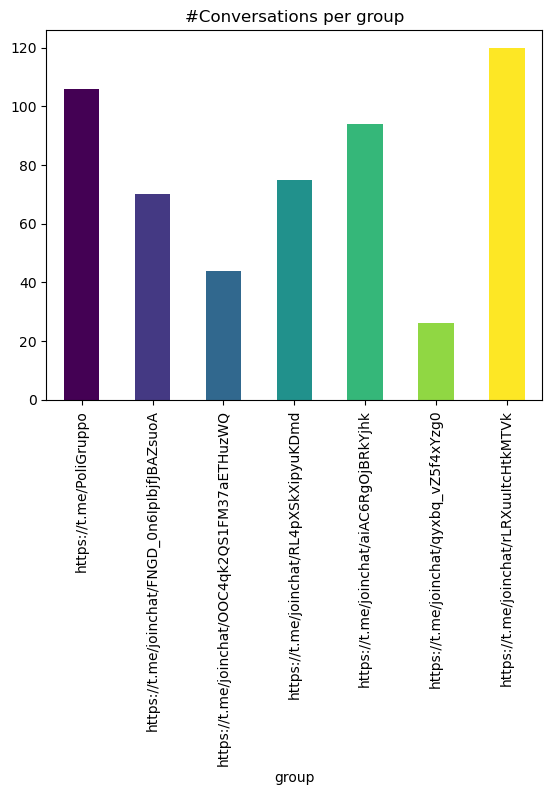

Messages per Conversations per Group in Average:
group
https://t.me/PoliGruppo                          2.584906
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     3.728571
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     5.704545
https://t.me/joinchat/RL4pXSkXipyuKDmd           3.560000
https://t.me/joinchat/aiAC6RgOjBRkYjhk           3.170213
https://t.me/joinchat/qyxbq_vZ5f4xYzg0          10.000000
https://t.me/joinchat/rLRXuuItcHtkMTVk           2.125000
dtype: float64


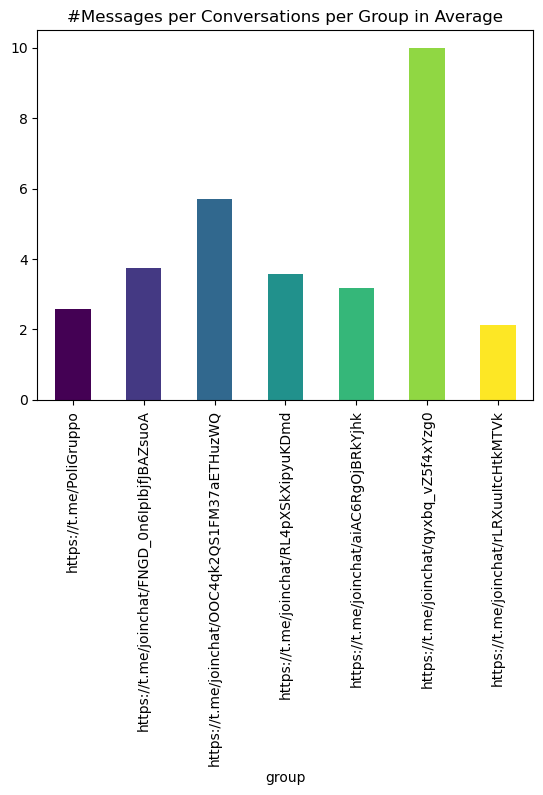

In [71]:
printstatistics(predf)

### Pre-processing phase

In [72]:
texts = [str(text) for text in predf['text']]
len(texts)

1866

The "preprocess_messages" function preprocesses all the messages by removing mentions, links, newline characters, and eliminating any empty words, preparing it for further analysis or processing.

In [73]:
pretexts = prerprocess_messages(texts)

In [74]:
watch_messages_in_a_range(pretexts, 810,815,0)

810 : What a story, thanks
811 : Dovrò ridarci un'occhiata allora
812 : Per esperienza personale dopo un po' che non viene usato webeep scede la sessione (tipo 5h o qualcosa del genere, non mi ricordo bene) L'altra cosa che potresti provare è di aprire una nuova pagina di firefox da 0, loggarti nei servizi online e salvare tutti i cookies che ci sono, questo dovrebbe permetterti di restare con gli stessi cookies con cui sei loggato anche se chiudi il browser
813 : After, if you actually keep all cookies works, you can try to remove one at a time and see when it breaks to save as little as possible
814 : How do you usually put the laptops to arrive on the market with the latest generation of installed components? Online most of the new laptops still have old components of a generation despite the fact that the new has been launched on the market since the beginning of the year.


#### Translating all the not-english messages

In [76]:
#This instruction took 1m 32s to run on my PC
tr_pretexts = translate_texts(pretexts)

In [77]:
watch_messages_in_a_range(tr_pretexts, 810,815,0)

810 : What a story, thanks
811 : I will have to take a look at it then
812 : From personal experience after a little that we are not used WeBeep, choose the session (type 5h or something like that, I don't remember well) the other thing you could try is to open a new page of 0 Firefox, log in to online services And save all the cookies that are there, this should allow you to stay with the same cookies with which you are logged in even if you close the browser
813 : After, if you actually keep all cookies works, you can try to remove one at a time and see when it breaks to save as little as possible
814 : How do you usually put the laptops to arrive on the market with the latest generation of installed components? Online most of the new laptops still have old components of a generation despite the fact that the new has been launched on the market since the beginning of the year.


In [78]:
tr_predf = predf.copy()
tr_predf['text'] = tr_pretexts
tr_predf = tr_predf[tr_predf['text'].apply(lambda x: len(x.split()) > 2)]
tr_predf.reset_index(drop=True, inplace=True)

Total Number of Conversations:
528

Total Number of Messages:
1665

Total Number of Reactions:
294

Messages per Conversation in average:
3.153409090909091

Conversations per group:
group
https://t.me/PoliGruppo                         100
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     70
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     44
https://t.me/joinchat/RL4pXSkXipyuKDmd           75
https://t.me/joinchat/aiAC6RgOjBRkYjhk           94
https://t.me/joinchat/qyxbq_vZ5f4xYzg0           26
https://t.me/joinchat/rLRXuuItcHtkMTVk          119
Name: conversation_id, dtype: int64


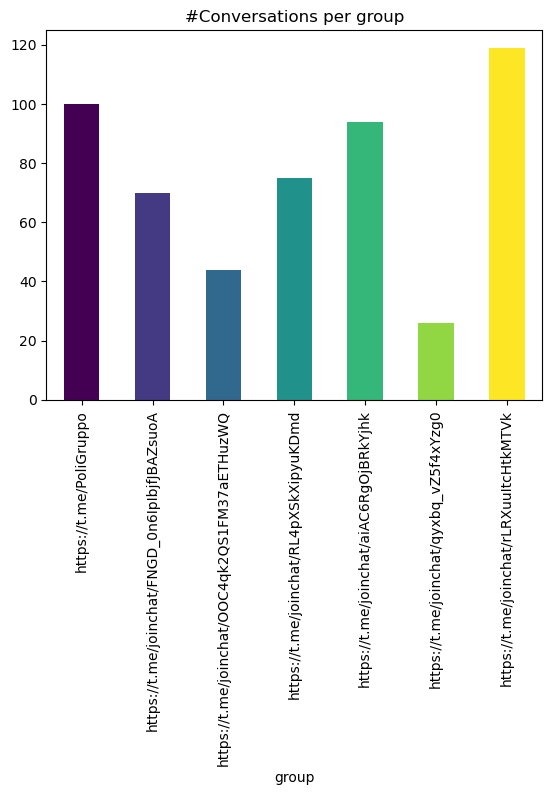

Messages per Conversations per Group in Average:
group
https://t.me/PoliGruppo                         2.380000
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA    3.385714
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ    5.250000
https://t.me/joinchat/RL4pXSkXipyuKDmd          3.200000
https://t.me/joinchat/aiAC6RgOjBRkYjhk          2.755319
https://t.me/joinchat/qyxbq_vZ5f4xYzg0          9.192308
https://t.me/joinchat/rLRXuuItcHtkMTVk          1.857143
dtype: float64


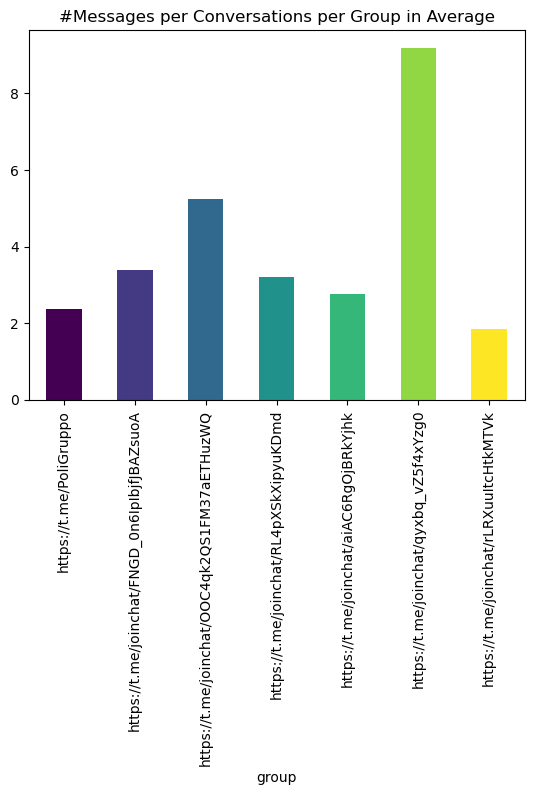

In [79]:
printstatistics(tr_predf)

In [85]:
tr_predf_embeddings = embed_dataframe(tr_predf,'en')

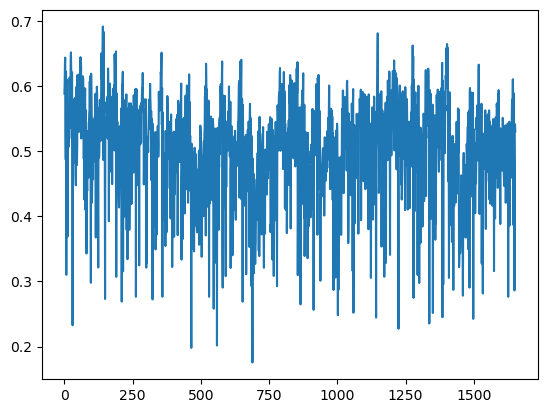

In [87]:
k2 = 12
pretr_similarities, pretr_indxs = cosine_similarities_last_k_sliding_window(tr_predf_embeddings, k2)

plt.plot(pretr_similarities)
plt.show()

In [88]:
pretr_treshold = find_suitable_treshold(pretr_similarities, tr_predf)
cosine_similarities_info(tr_predf, pretr_similarities, pretr_treshold, k2)

treshold = 0.4890000000000004

Index with the minimum cosine similarity: 
[689]

Indices with cosine similarity below the treshold:
[17, 19, 23, 24, 42, 44, 53, 54, 56, 58, 85, 89, 91, 93, 95, 96, 99, 100, 109, 113, 114, 116, 117, 122, 127, 129, 133, 135, 136, 154, 160, 161, 175, 180, 182, 187, 202, 205, 211, 212, 213, 216, 217, 222, 227, 231, 240, 243, 245, 250, 251, 256, 257, 258, 259, 265, 274, 279, 282, 283, 286, 303, 304, 312, 314, 331, 335, 338, 340, 346, 347, 348, 350, 371, 374, 375, 376, 377, 379, 380, 382, 386, 395, 398, 401, 404, 407, 408, 409, 410, 411, 412, 414, 416, 417, 418, 419, 423, 427, 428, 433, 441, 442, 446, 452, 453, 457, 465, 470, 474, 476, 477, 479, 481, 482, 483, 484, 485, 486, 487, 488, 491, 492, 493, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 506, 507, 509, 512, 514, 515, 516, 517, 518, 519, 520, 524, 530, 533, 535, 538, 539, 542, 544, 545, 551, 553, 554, 558, 559, 560, 565, 568, 571, 575, 577, 579, 591, 592, 601, 602, 603, 605, 621, 622, 626, 628, 629,

#### Removing all the english stopwords from the texts to remove redundant informations

In [89]:
pre_tr_pretexts = remove_stopwords_from_messages(tr_pretexts, 'english')
watch_messages_in_a_range(pre_tr_pretexts, 810,815,0)

810 : What story, thanks
811 : I take look
812 : From personal experience little used WeBeep, choose session (type 5h something like that, I remember well) thing could try open new page 0 Firefox, log online services And save cookies there, allow stay cookies logged even close browser
813 : After, actually keep cookies works, try remove one time see breaks save little possible
814 : How usually put laptops arrive market latest generation installed components? Online new laptops still old components generation despite fact new launched market since beginning year.


In [90]:
print(predf['text'][810:814])
print("\nDataframe shape:")
print(predf.shape)

810                                 What a story, thanks
811                     Dovrò ridarci un'occhiata allora
812    Per esperienza personale dopo un po' che non v...
813    After, if you actually keep all cookies works,...
Name: text, dtype: object

Dataframe shape:
(1866, 8)


#### Removing all messages with less than two words

In [91]:
new_predf = predf.copy()
new_predf['text'] = pre_tr_pretexts
print(new_predf['text'][810:814])
new_predf = new_predf[new_predf['text'].apply(lambda x: len(x.split()) > 2)]
new_predf.reset_index(drop=True, inplace=True)
print("\nNew Dataframe Shape after Removing Messages with Less than two words:")
print(new_predf.shape)

810                                   What story, thanks
811                                          I take look
812    From personal experience little used WeBeep, c...
813    After, actually keep cookies works, try remove...
Name: text, dtype: object

New Dataframe Shape after Removing Messages with Less than two words:
(1610, 8)


Total Number of Conversations:
527

Total Number of Messages:
1610

Total Number of Reactions:
270

Messages per Conversation in average:
3.0550284629981026

Conversations per group:
group
https://t.me/PoliGruppo                         100
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA     70
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ     44
https://t.me/joinchat/RL4pXSkXipyuKDmd           75
https://t.me/joinchat/aiAC6RgOjBRkYjhk           94
https://t.me/joinchat/qyxbq_vZ5f4xYzg0           26
https://t.me/joinchat/rLRXuuItcHtkMTVk          118
Name: conversation_id, dtype: int64


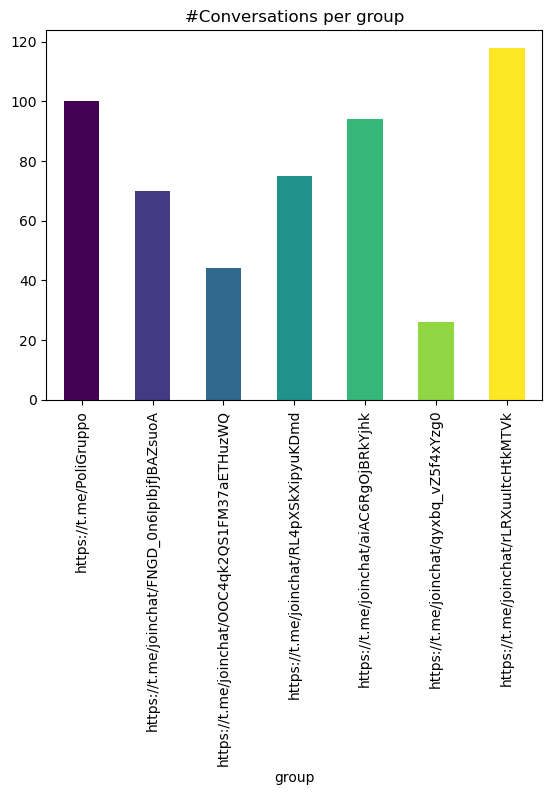

Messages per Conversations per Group in Average:
group
https://t.me/PoliGruppo                         2.280000
https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA    3.300000
https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ    5.136364
https://t.me/joinchat/RL4pXSkXipyuKDmd          3.120000
https://t.me/joinchat/aiAC6RgOjBRkYjhk          2.691489
https://t.me/joinchat/qyxbq_vZ5f4xYzg0          8.615385
https://t.me/joinchat/rLRXuuItcHtkMTVk          1.813559
dtype: float64


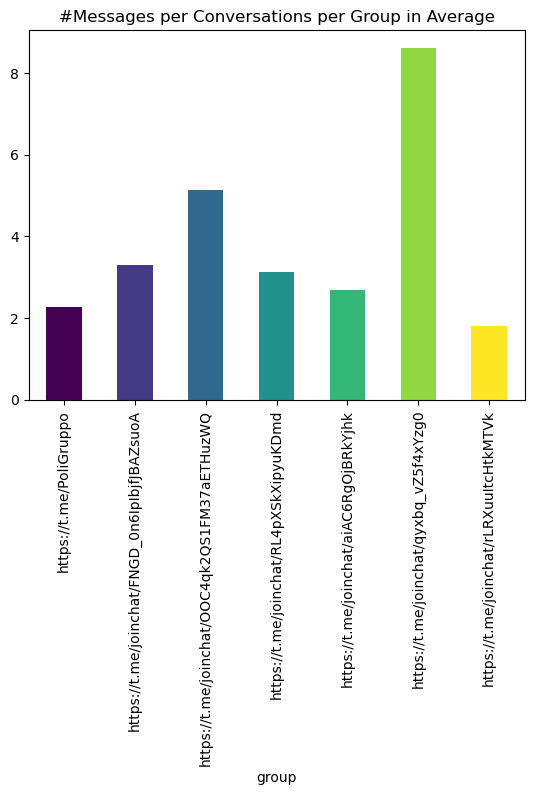

In [92]:
printstatistics(new_predf)

### Testing the Cosine Similarities Method on the Pre-Processed Dataframe

In [93]:
pre_embeddings = embed_dataframe(new_predf,'en')

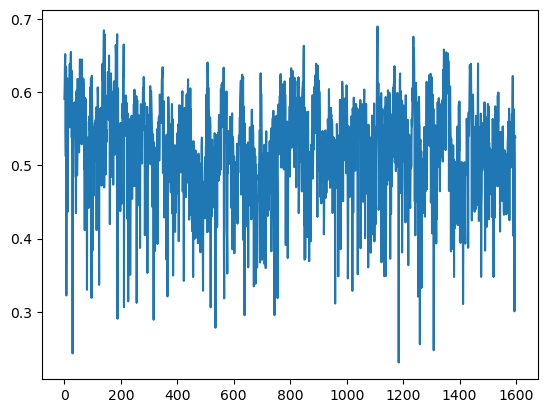

In [95]:
k2 = 12
pre_similarities, pre_indxs = cosine_similarities_last_k_sliding_window(pre_embeddings, k2)

plt.plot(pre_similarities)
plt.show()

In [96]:
pre_treshold = find_suitable_treshold(pre_similarities, new_predf)

In [97]:
cosine_similarities_info(new_predf, pre_similarities, pre_treshold, k2)

treshold = 0.5030000000000003

Index with the minimum cosine similarity: 
[1184]

Indices with cosine similarity below the treshold:
[19, 23, 41, 43, 53, 55, 57, 82, 84, 88, 90, 92, 94, 95, 98, 99, 108, 112, 113, 115, 116, 126, 128, 132, 134, 135, 144, 153, 159, 173, 180, 185, 200, 203, 207, 209, 210, 211, 213, 214, 223, 235, 238, 240, 243, 245, 246, 247, 251, 252, 253, 257, 259, 262, 268, 271, 273, 276, 277, 280, 287, 297, 298, 306, 308, 317, 324, 328, 331, 333, 334, 337, 339, 342, 361, 365, 366, 367, 368, 370, 371, 373, 375, 376, 377, 379, 386, 388, 389, 391, 394, 397, 398, 399, 400, 401, 402, 404, 406, 407, 408, 409, 413, 417, 418, 423, 431, 435, 441, 442, 443, 446, 451, 452, 454, 459, 461, 463, 465, 468, 470, 471, 472, 474, 475, 476, 479, 480, 481, 482, 484, 485, 486, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 512, 518, 521, 523, 526, 527, 530, 532, 533, 539, 541, 542, 546, 547, 548, 550, 553, 555, 558, 562, 565, 577, 578, 58

In [99]:
pre_table, pre_headers = print_results_table(new_predf, pre_embeddings, 2, 10)

100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


In [102]:
save_results(pre_table, pre_headers, "pre_cos_sim_results.xlsx")